## DSC-680 Project#2

### Name: <span style="font-size: smaller;">Syed Shahid Shabbir</span>

### Club Soccer Predictions 


##### Project Overview
This project seeks to address key questions related to the evolution and variability of Soccer Power Index (SPI) data over time and across leagues. Specifically, the focus is on understanding:

1.	How SPI changes over time: Analyzing trends for the top ten ranked clubs (as of 12/2/19) alongside mid-range clubs to identify stability and fluctuations in team performance and the factors driving these changes.
2.	Comparing different leagues: Evaluating SPI trends across various leagues to uncover meaningful insights about league characteristics, such as team balance, strategy, and overall strength. The large volume of data and the diversity of leagues present challenges in visualizing and extracting actionable information.


By addressing these questions, the project aims to enhance the understanding of team and league performance dynamics, contributing to improved predictive modeling and informed decision-making for stakeholders.


#### SPI ratings
At the heart of our club soccer forecasts are FiveThirtyEight’s SPI ratings, which are our best estimate of a team’s overall strength. In our system, every team has an offensive rating that represents the number of goals it would be expected to score against an average team on a neutral field, and a defensive rating that represents the number of goals it would be expected to concede. These ratings, in turn, produce an overall SPI rating, which represents the percentage of available points — a win is worth 3 points, a tie worth 1 point, and a loss worth 0 points — the team would be expected to take if that match were played over and over again.

Given the ratings for any two teams, we can project the result of a match between them in a variety of formats — such as a league match, a home-and-away tie or a cup final — as well as simulate whole seasons to arrive at the probability each team will win the league, qualify for the Champions League or be relegated to a lower division.

Before a season begins, a team’s SPI ratings are based on two factors: its ratings at the end of the previous season, and its market value as calculated by Transfermarkt (a site that assigns a monetary value to each player, based on what they would fetch in a transfer). We’ve found that a team’s market value — relative to their league’s average value — is strongly correlated with its end-of-season SPI rating. Thus, we use these market values to infer each team’s preseason SPI rating.

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
from pmdarima import auto_arima

##### Load the Dataset and Initial Inspection
We will first load the dataset using pandas and inspect the first few rows to get an understanding of the data.



In [137]:
data = pd.read_csv("F:\spi_matches.csv")
data.head()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
0,2016,2016-07-09,7921,FA Women's Super League,Liverpool Women,Reading,51.56,50.42,0.4389,0.2767,...,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,2016-07-10,7921,FA Women's Super League,Arsenal Women,Notts County Ladies,46.61,54.03,0.3572,0.3608,...,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,2016-07-10,7921,FA Women's Super League,Chelsea FC Women,Birmingham City,59.85,54.64,0.4799,0.2487,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,2016-07-16,7921,FA Women's Super League,Liverpool Women,Notts County Ladies,53.00,52.35,0.4289,0.2699,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,2016-07-17,7921,FA Women's Super League,Chelsea FC Women,Arsenal Women,59.43,60.99,0.4124,0.3157,...,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


##### Data Cleaning
Before we proceed with graphical analysis, we will perform some basic data cleaning such as handling missing values and ensuring the data types are correct.

In [138]:
# Remove rows with missing scores and keep relevant columns 
# Since our main feature is score, we will emphasize on it
cleaned_data = data.dropna(subset=['score1', 'score2'])

In [139]:
cleaned_data.columns

Index(['season', 'date', 'league_id', 'league', 'team1', 'team2', 'spi1',
       'spi2', 'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2',
       'importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 'nsxg1',
       'nsxg2', 'adj_score1', 'adj_score2'],
      dtype='object')

In [140]:
# Removing irrelevant features 
relevant_columns = [
    'season', 'date', 'league', 'team1', 'team2', 
    'spi1', 'spi2', 'score1', 'score2', 
    'xg1', 'xg2', 'nsxg1', 'nsxg2', 'importance1', 'importance2'
]
cleaned_data = cleaned_data[relevant_columns]

In [141]:
# Convert 'date' column to datetime
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

In [142]:
# Display the cleaned data
cleaned_data.head()

,season,date,league,team1,team2,spi1,spi2,score1,score2,xg1,xg2,nsxg1,nsxg2,importance1,importance2
0,2016,2016-07-09,FA Women's Super League,Liverpool Women,Reading,51.56,50.42,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,2016-07-10,FA Women's Super League,Arsenal Women,Notts County Ladies,46.61,54.03,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,2016-07-10,FA Women's Super League,Chelsea FC Women,Birmingham City,59.85,54.64,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,2016-07-16,FA Women's Super League,Liverpool Women,Notts County Ladies,53.00,52.35,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,2016-07-17,FA Women's Super League,Chelsea FC Women,Arsenal Women,59.43,60.99,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Top 30 Teams Based on the Average SPI Score 

In [144]:
# Step 1: Calculate the average SPI for each team
average_spi = cleaned_data.groupby('team1')['spi1'].mean().reset_index()

# Step 2: Sort the teams by average SPI in descending order and extract the top 5
average_spi = average_spi.sort_values(by='spi1', ascending=False).reset_index(drop=True)
average_spi['rank'] = average_spi.index + 1

# Step 3: Extract the top 10 teams
top_30_teams = average_spi.head(30)
top_30_teams

,team1,spi1,rank
0,Bayern Munich,92.567059,1
1,Manchester City,92.046977,2
2,Barcelona,90.555952,3
3,Real Madrid,88.781977,4
4,Liverpool,88.322606,5
5,Paris Saint-Germain,87.328931,6
6,Chelsea,84.979758,7
7,Atletico Madrid,84.486145,8
8,Borussia Dortmund,83.037467,9
9,Juventus,82.343018,10


In [166]:
average_spi.head(30)

,team1,spi1,rank
0,Bayern Munich,92.567059,1
1,Manchester City,92.046977,2
2,Barcelona,90.555952,3
3,Real Madrid,88.781977,4
4,Liverpool,88.322606,5
5,Paris Saint-Germain,87.328931,6
6,Chelsea,84.979758,7
7,Atletico Madrid,84.486145,8
8,Borussia Dortmund,83.037467,9
9,Juventus,82.343018,10


#### Trend Over Time for Selected Teams

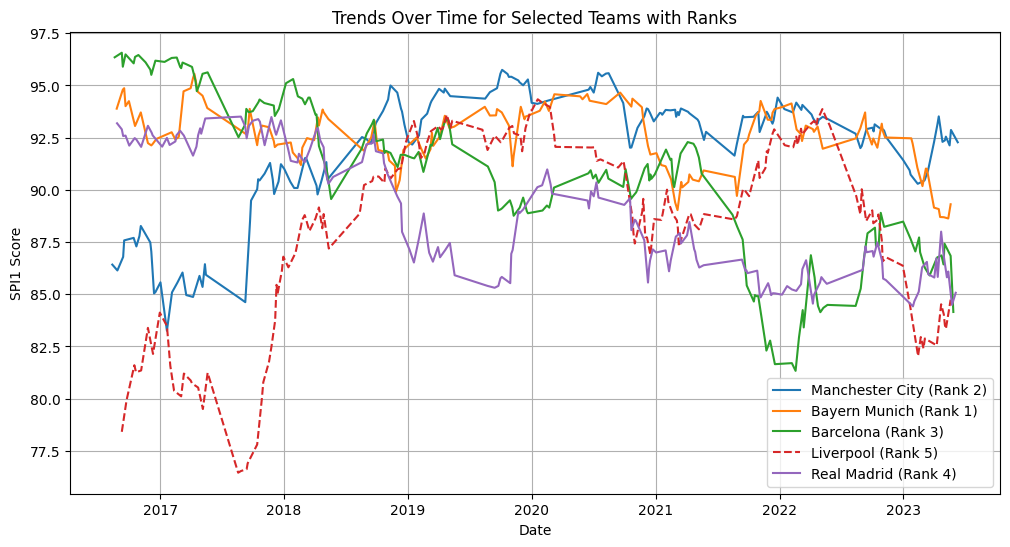

In [145]:
# Plot SPI1 trends over time for each team with customized line styles based on rank
plt.figure(figsize=(12, 6))

# Plotting SPI1 trends for each selected team
for team in selected_teams:
    team_data = filtered_data[filtered_data['team1'] == team]
    # Use a dotted line if the team's rank is between 5 and 10
    line_style = '--' if 5 <= team_ranks[team] <= 10 else '-'
    plt.plot(team_data['date'], team_data['spi1'], label=f"{team} (Rank {team_ranks[team]})", linestyle=line_style)

plt.title('Trends Over Time for Selected Teams with Ranks')
plt.xlabel('Date')
plt.ylabel('SPI1 Score')
plt.legend()
plt.grid()
plt.show()


### Displaying Top 20 and Bottom 20 Teams Defensive and Offensive Index

C:\Users\Utility\AppData\Local\Temp\ipykernel_7352\2102659519.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  top_20_cmap = cm.get_cmap('Greens', 20)  # Gradient green for top 20
C:\Users\Utility\AppData\Local\Temp\ipykernel_7352\2102659519.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bottom_20_cmap = cm.get_cmap('Reds', 20)  # Gradient red for bottom 20


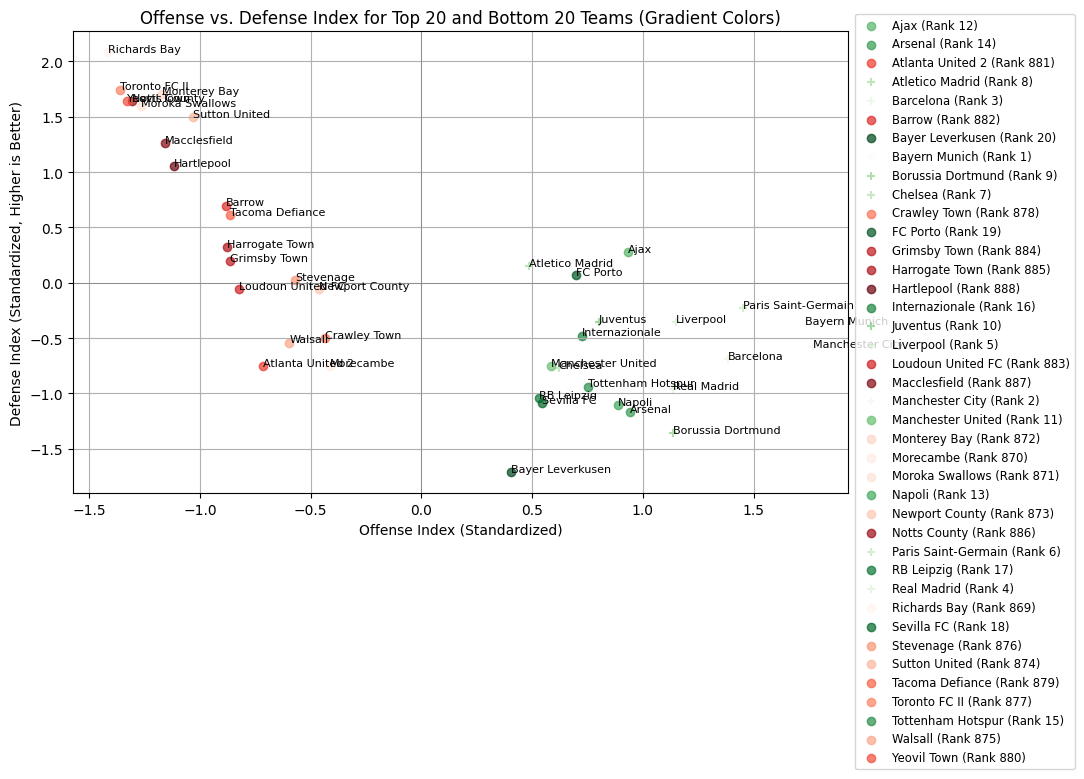

In [82]:
# Get the top 20 and bottom 20 teams based on average SPI
top_20_teams = average_spi.head(20)['team1'].tolist()
top_10_teams = average_spi.head(10)['team1'].tolist()  # Top 10 teams for special marker
bottom_20_teams = average_spi.tail(20)['team1'].tolist()

# Step 2: Filter goal data for only top 20 and bottom 20 teams
goal_data_top_bottom = goal_data[goal_data['team'].isin(top_20_teams + bottom_20_teams)]

# Step 3: Aggregate data to calculate total goals scored and conceded by these teams
aggregated_goals_top_bottom = goal_data_top_bottom.groupby('team').agg({'goals_scored': 'sum', 'goals_conceded': 'sum'}).reset_index()

# Step 4: Calculate the offense and defense index for each team
aggregated_goals_top_bottom['offense_index'] = aggregated_goals_top_bottom['goals_scored'] / aggregated_goals_top_bottom['goals_scored'].max()
aggregated_goals_top_bottom['defense_index'] = aggregated_goals_top_bottom['goals_conceded'] / aggregated_goals_top_bottom['goals_conceded'].max()

# Step 5: Standardize the offense and defense indices
scaler = StandardScaler()
aggregated_goals_top_bottom[['offense_index', 'defense_index']] = scaler.fit_transform(aggregated_goals_top_bottom[['offense_index', 'defense_index']])

# Step 6: Multiply the defense index by -1 to ensure higher values mean better performance
aggregated_goals_top_bottom['defense_index'] = -1 * aggregated_goals_top_bottom['defense_index']

# Step 7: Scatter plot for offense vs. defense for top 20 and bottom 20 teams with gradient colors and rank in legend
plt.figure(figsize=(10, 6))

# Create color maps for top 20 and bottom 20 teams
top_20_cmap = cm.get_cmap('Greens', 20)  # Gradient green for top 20
bottom_20_cmap = cm.get_cmap('Reds', 20)  # Gradient red for bottom 20

# Plot with gradient colors for top 20 (green) and bottom 20 (red), and '+' for top 10 teams
for i, row in aggregated_goals_top_bottom.iterrows():
    team_name = row['team']
    # Determine color based on team position (top 20 or bottom 20) and scale gradient
    if team_name in top_20_teams:
        color = top_20_cmap(top_20_teams.index(team_name) / 19)
        marker = '+' if team_name in top_10_teams else 'o'
    else:
        color = bottom_20_cmap(bottom_20_teams.index(team_name) / 19)
        marker = 'o'
    
    # Label with team name and rank
    rank = average_spi[average_spi['team1'] == team_name]['rank'].values[0]
    label = f"{team_name} (Rank {rank})"
    
    # Plot the point
    plt.scatter(row['offense_index'], row['defense_index'], marker=marker, alpha=0.7, color=color, label=label if label not in plt.gca().get_legend_handles_labels()[1] else "")

# Annotate each team
for i, txt in enumerate(aggregated_goals_top_bottom['team']):
    plt.annotate(txt, (aggregated_goals_top_bottom['offense_index'][i], aggregated_goals_top_bottom['defense_index'][i]), fontsize=8)

plt.title('Offense vs. Defense Index for Top 20 and Bottom 20 Teams (Gradient Colors)')
plt.xlabel('Offense Index (Standardized)')
plt.ylabel('Defense Index (Standardized, Higher is Better)')
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid()

# Adjust legend outside the plot area with smaller font size
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.05), fontsize='small')
plt.show()

### Inference:

- **What Are We Getting From This Plot?**

The plot helps visualize the offensive and defensive strengths of the top 20 and bottom 20 teams.

- **Teams in the Upper Right Quadrant:** Typically, these teams exhibit balanced and strong performance both offensively and defensively. This group primarily includes higher-ranked teams.

- **Teams in the Lower Right Quadrant:** Teams here tend to have good offensive capabilities but weaker defensive performance. These teams may rely on scoring more goals rather than defending.

- **Teams in the Upper Left Quadrant:** These teams focus more on defense, with fewer goals conceded but may struggle to score.

- **Teams in the Lower Left Quadrant:** Teams in this area are generally weaker overall, struggling both offensively and defensively.

The color gradients and marker types help differentiate the performance characteristics of teams across the rankings, providing insights into their strategic strengths and weaknesses.


#### Average SPI by League

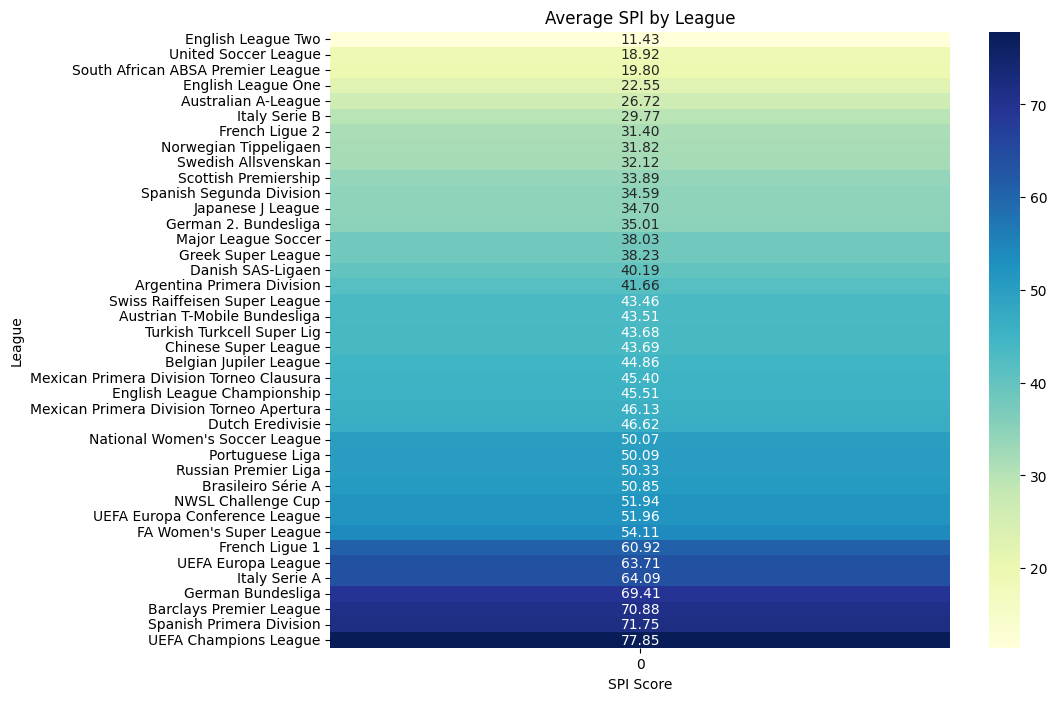

In [45]:
# Heat map for league performance comparison
plt.figure(figsize=(10, 8))

# Calculate average SPI for each league
league_performance = cleaned_data.groupby('league')[['spi1', 'spi2']].mean().mean(axis=1).sort_values()

# Plot heat map
sns.heatmap(league_performance.values.reshape(-1, 1), annot=True, fmt=".2f", cmap="YlGnBu", yticklabels=league_performance.index)
plt.title('Average SPI by League')
plt.xlabel('SPI Score')
plt.ylabel('League')
plt.show()

### Inferences from the Heatmap of Average SPI by League

The heatmap provides a visual representation of the average Soccer Power Index (SPI) scores for different leagues. It allows us to compare the relative performance of various leagues based on their average SPI values.

#### What the Plot Shows:
1. **Heatmap of Average SPI by League:**
   - The heatmap visualizes the average SPI scores for each league, using color gradients to indicate the magnitude of the SPI values.
   - Leagues with higher average SPI scores are represented by darker shades, while leagues with lower SPI scores are shown in lighter shades.

2. **SPI Score as a Measure of Overall League Strength:**
   - The SPI score is used to evaluate the overall quality or strength of teams within each league. Higher average SPI scores indicate that teams in that league generally perform better.

#### Inferences from the Heatmap:
1. **League Performance Comparison:**
   - The heatmap helps in comparing the relative strength of different leagues. Leagues with higher average SPI values (darker shades) can be considered stronger and more competitive.
   - Leagues with lower SPI values may indicate weaker overall team performance or that the league is less competitive compared to those with higher SPI scores.

2. **Insights into Competitive Balance:**
   - The variation in SPI scores across different leagues provides insights into competitive balance. Significant differences in average SPI scores between leagues suggest that certain leagues have a higher concentration of top-performing teams.
   
3. **Strategic Implications:**
   - For teams preparing for international tournaments, the average league SPI can provide an indication of the quality of competition they may face.
   - Leagues with higher average SPI scores could be considered as having tougher competition, potentially offering a more rigorous preparation for teams aiming to perform well internationally.

#### Key Takeaways:
- **Top-Performing Leagues:** Leagues with the highest average SPI scores have the most competitive teams, which could imply better infrastructure, coaching, and player quality.
- **Leagues Needing Improvement:** Leagues with lower average SPI scores may need to focus on enhancing the quality of their teams to be more competitive on an international level.
- **Strategic Analysis:** The heatmap helps clubs and league organizers assess their standing relative to other leagues, providing insights that can drive data-driven decisions to improve league quality.

Overall, the heatmap serves as a visual representation of league strength, making it easier to identify which leagues have stronger or weaker average team performances.


#### Prediction of Ranking Based on the Predictive Models

In [ ]:
#  Calculate the average SPI for each team and get the top 30 teams based on average SPI
average_spi = cleaned_data.groupby('team1')['spi1'].mean().reset_index()
average_spi = average_spi.sort_values(by='spi1', ascending=False).reset_index(drop=True)
top_30_spi_teams = average_spi.head(30)['team1'].tolist()

#  Filter the data for the top 30 teams based on average SPI
top_30_spi_data = cleaned_data[cleaned_data['team1'].isin(top_30_spi_teams)]

#  Prepare the time series data for modeling based on average SPI1 for the top 30 teams
time_series_spi1_data = top_30_spi_data.groupby(['team1', 'date']).agg({
    'spi1': 'mean'
}).reset_index()

# Train Random Forest Regressor to predict future average SPI1 score for the top 30 teams
predictions_rf_spi1_30 = {}
for team in top_30_spi_teams:
    # Extract team-specific data
    team_data = time_series_spi1_data[time_series_spi1_data['team1'] == team].sort_values(by='date')
    X = np.array(range(len(team_data))).reshape(-1, 1)  # Time steps as features
    y = team_data['spi1'].values  # Predicting average SPI1 score

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict future SPI1 scores
    y_pred_rf = rf_model.predict(np.array(range(len(X), len(X) + 5)).reshape(-1, 1))  # Predict next 5 steps
    predictions_rf_spi1_30[team] = y_pred_rf

#  Train ARIMA model using auto_arima() for top 30 teams based on average SPI1
predictions_arima_spi1_30 = {}
for team in top_30_spi_teams:
    # Extract team-specific data
    team_data = time_series_spi1_data[time_series_spi1_data['team1'] == team].sort_values(by='date')
    spi1_series = team_data['spi1']

    # Fit ARIMA model
    arima_model = auto_arima(spi1_series, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    arima_model.fit(spi1_series)

    # Predict next 5 steps
    forecast_arima = arima_model.predict(n_periods=5)
    predictions_arima_spi1_30[team] = forecast_arima


In [ ]:
# Step 6: Estimate rank changes based on the predicted average SPI1 scores from both models
future_ranks_combined = {}
for step in range(5):
    # Gather predictions for the current step for both models
    future_spi1_scores_combined = []
    for team in top_30_spi_teams:
        # Convert the predictions to a list to ensure proper indexing
        rf_predictions = list(predictions_rf_spi1_30.get(team, []))
        arima_predictions = list(predictions_arima_spi1_30.get(team, []))
        
        # Check if predictions for the current step are available for both models
        if len(rf_predictions) > step and len(arima_predictions) > step:
            rf_pred = rf_predictions[step]
            arima_pred = arima_predictions[step]
            future_spi1_scores_combined.append((team, rf_pred, arima_pred))
    
    # Sort teams based on the average of the predictions
    sorted_teams_combined = sorted(future_spi1_scores_combined, key=lambda x: (x[1] + x[2]) / 2, reverse=True)
    # Update rank changes for each team
    future_ranks_combined[step + 1] = {team[0]: rank + 1 for rank, team in enumerate(sorted_teams_combined)}

# Step 7: Calculate the initial ranks based on the original order of top 30 teams
previous_ranks = {team: rank + 1 for rank, team in enumerate(top_30_spi_teams)}

# Step 8: Show the predicted ranks and compare with previous ranks for each time step
comparison_ranks = {}
for year in range(1, 6):  # Future time steps (next 5 years)
    predicted_ranks = future_ranks_combined[year]  # Get predicted ranks for the current step
    rank_comparison = {
        team: {'Previous Rank': previous_ranks.get(team, 'N/A'), 'Predicted Rank': predicted_ranks.get(team, 'N/A')}
        for team in top_30_spi_teams
    }
    comparison_ranks[year] = rank_comparison


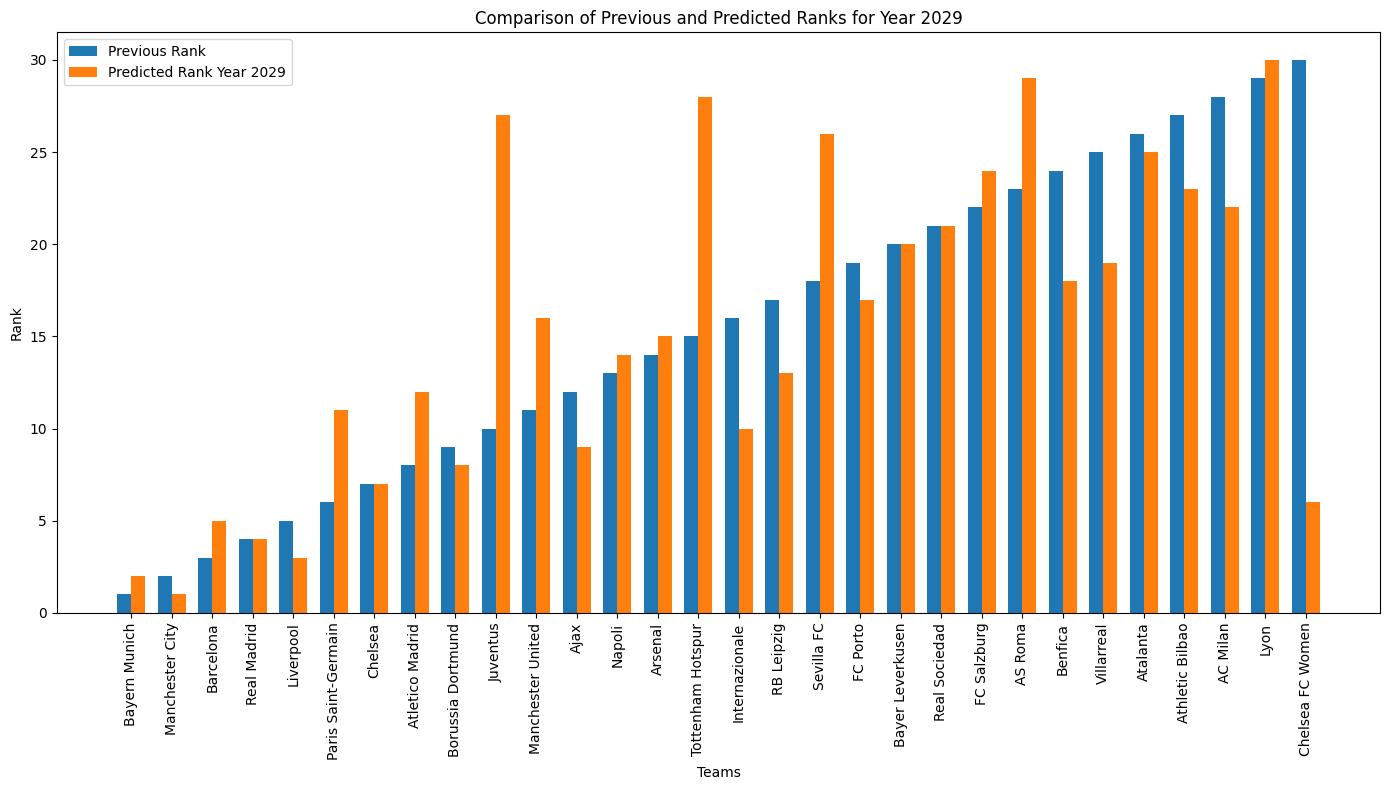

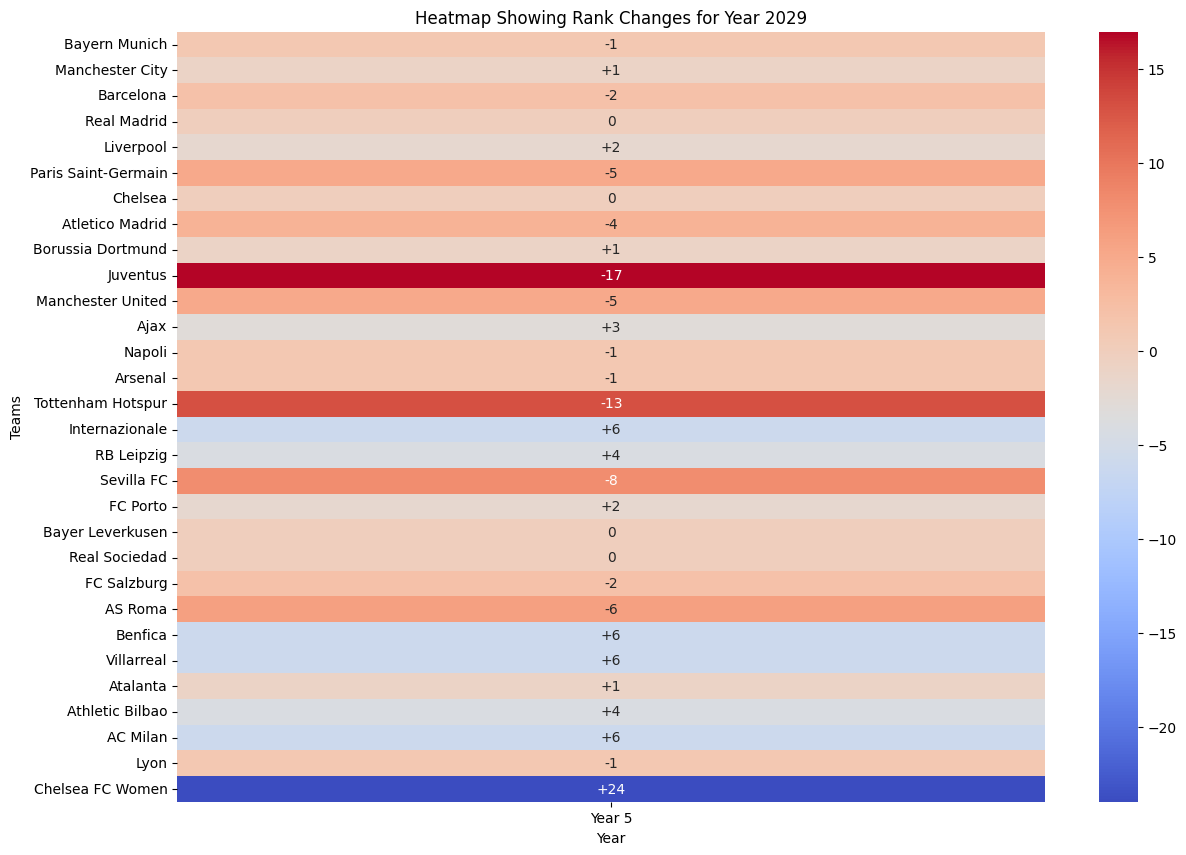

In [128]:

# Bar Plot Comparing Previous and Predicted Ranks for the Last Year (Year 5)
year = 5
plt.figure(figsize=(14, 8))
teams = list(comparison_ranks[year].keys())
previous_ranks = [comparison_ranks[year][team]['Previous Rank'] for team in teams]
predicted_ranks = [comparison_ranks[year][team]['Predicted Rank'] for team in teams]

# Plotting the previous and predicted ranks side by side
bar_width = 0.35
index = np.arange(len(teams))
plt.bar(index, previous_ranks, bar_width, label='Previous Rank')
plt.bar(index + bar_width, predicted_ranks, bar_width, label=f'Predicted Rank Year 2029')

plt.title(f'Comparison of Previous and Predicted Ranks for Year 2029')
plt.xlabel('Teams')
plt.ylabel('Rank')
plt.xticks(index + bar_width / 2, teams, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


# Heatmap Showing Rank Changes for the Last Year (Year 5) with "+X" or "−X" annotations
rank_changes = []
rank_change_values = []
teams_order = list(comparison_ranks[5].keys())  # Teams for Year 5

for team in teams_order:
    prev_rank = comparison_ranks[5][team]['Previous Rank']
    predicted_rank = comparison_ranks[5][team]['Predicted Rank']
    # Calculate the rank change
    change_value = predicted_rank - prev_rank
    rank_change_values.append(change_value)
    # Use "+" or "-" sign based on the change direction
    if change_value < 0:
        rank_changes.append(f"+{abs(change_value)}")
    elif change_value > 0:
        rank_changes.append(f"-{abs(change_value)}")
    else:
        rank_changes.append("0")  # No change

# Convert rank_change_values to a numpy array for heatmap
rank_change_values = np.array(rank_change_values).reshape(-1, 1)

plt.figure(figsize=(14, 10))
sns.heatmap(rank_change_values, annot=np.array(rank_changes).reshape(-1, 1), fmt="", cmap='coolwarm', 
            xticklabels=[f'Year 5'], yticklabels=teams_order, cbar=True)

plt.title('Heatmap Showing Rank Changes for Year 2029')
plt.xlabel('Year')
plt.ylabel('Teams')
plt.show()



In [129]:
# Create a DataFrame to display the previous rank and predicted rank for Year 5
year = 5
teams = list(comparison_ranks[year].keys())
previous_ranks = [comparison_ranks[year][team]['Previous Rank'] for team in teams]
predicted_ranks = [comparison_ranks[year][team]['Predicted Rank'] for team in teams]

# Create the DataFrame
rank_comparison_df = pd.DataFrame({
    'Team': teams,
    'Previous Rank': previous_ranks,
    'Predicted Rank': predicted_ranks
})

# Sort the DataFrame by Predicted Rank for better visualization
rank_comparison_df = rank_comparison_df.sort_values(by='Predicted Rank').reset_index(drop=True)

# Display the table
rank_comparison_df

,Team,Previous Rank,Predicted Rank
0,Manchester City,2,1
1,Bayern Munich,1,2
2,Liverpool,5,3
3,Real Madrid,4,4
4,Barcelona,3,5
5,Chelsea FC Women,30,6
6,Chelsea,7,7
7,Borussia Dortmund,9,8
8,Ajax,12,9
9,Internazionale,16,10


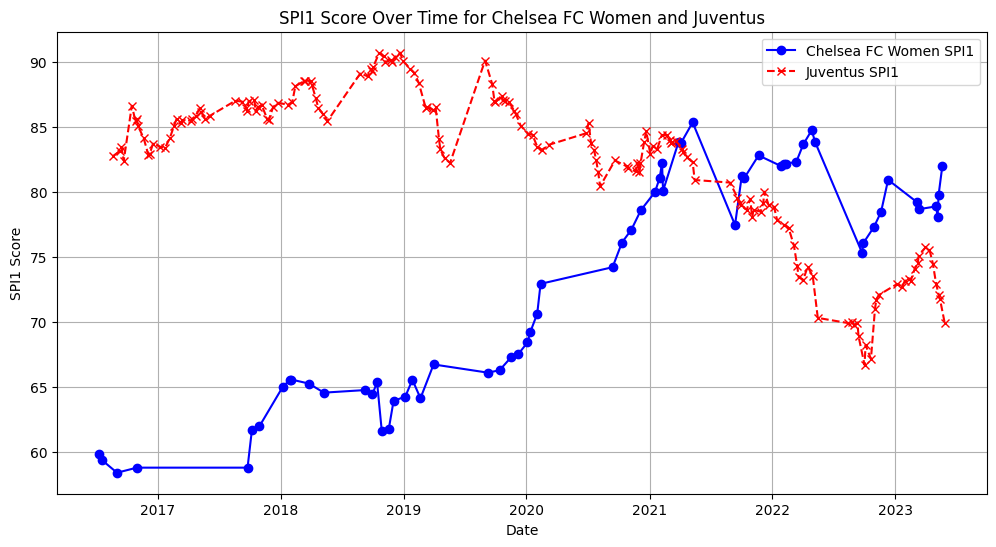

In [157]:
# Filter the data for Chelsea FC Women and Juventus
chelsea_women_data = cleaned_data[cleaned_data['team1'] == 'Chelsea FC Women'].sort_values(by='date')
juventus_data = cleaned_data[cleaned_data['team1'] == 'Juventus'].sort_values(by='date')

# Plot the SPI1 score over time for both teams
plt.figure(figsize=(12, 6))
plt.plot(chelsea_women_data['date'], chelsea_women_data['spi1'], marker='o', linestyle='-', color='b', label='Chelsea FC Women SPI1')
plt.plot(juventus_data['date'], juventus_data['spi1'], marker='x', linestyle='--', color='r', label='Juventus SPI1')

# Adding title, labels, and legend
plt.title('SPI1 Score Over Time for Chelsea FC Women and Juventus')
plt.xlabel('Date')
plt.ylabel('SPI1 Score')
plt.legend()
plt.grid()
plt.show()


##### Calculating the RMSE and MAE Score

In [132]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize dictionaries to store errors for each team
rmse_rf = {}
mae_rf = {}
rmse_arima = {}
mae_arima = {}

# Number of years (or time steps) to use for the test set
test_period = 5

# Calculate errors for each team in the top 30 using the last 5 years as the test set
for team in top_30_spi_teams:
    # Get the team-specific data and sort by date
    team_data = time_series_spi1_data[time_series_spi1_data['team1'] == team].sort_values(by='date')
    y = team_data['spi1'].values
    X = np.array(range(len(y))).reshape(-1, 1)  # Time steps as features

    # Use all data except the last 5 years for training, and the last 5 years for testing
    X_train, X_test = X[:-test_period], X[-test_period:]
    y_train, y_test = y[:-test_period], y[-test_period:]

    # Train Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Train ARIMA model on the training data
    arima_model = auto_arima(y_train, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
    arima_model.fit(y_train)
    y_pred_arima = arima_model.predict(n_periods=test_period)

    # Compute RMSE and MAE for Random Forest
    rmse_rf[team] = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mae_rf[team] = mean_absolute_error(y_test, y_pred_rf)

    # Compute RMSE and MAE for ARIMA
    rmse_arima[team] = np.sqrt(mean_squared_error(y_test, y_pred_arima))
    mae_arima[team] = mean_absolute_error(y_test, y_pred_arima)

# Calculate the overall RMSE and MAE for Random Forest
overall_rmse_rf = np.mean(list(rmse_rf.values()))
overall_mae_rf = np.mean(list(mae_rf.values()))

# Calculate the overall RMSE and MAE for ARIMA
overall_rmse_arima = np.mean(list(rmse_arima.values()))
overall_mae_arima = np.mean(list(mae_arima.values()))

# Display the results
print(f"Random Forest Overall Performance:\nRMSE: {overall_rmse_rf:.4f}\nMAE: {overall_mae_rf:.4f}\n")
print(f"ARIMA Overall Performance:\nRMSE: {overall_rmse_arima:.4f}\nMAE: {overall_mae_arima:.4f}\n")


Random Forest Overall Performance:
RMSE: 1.7559
MAE: 1.5324

ARIMA Overall Performance:
RMSE: 1.7385
MAE: 1.5207



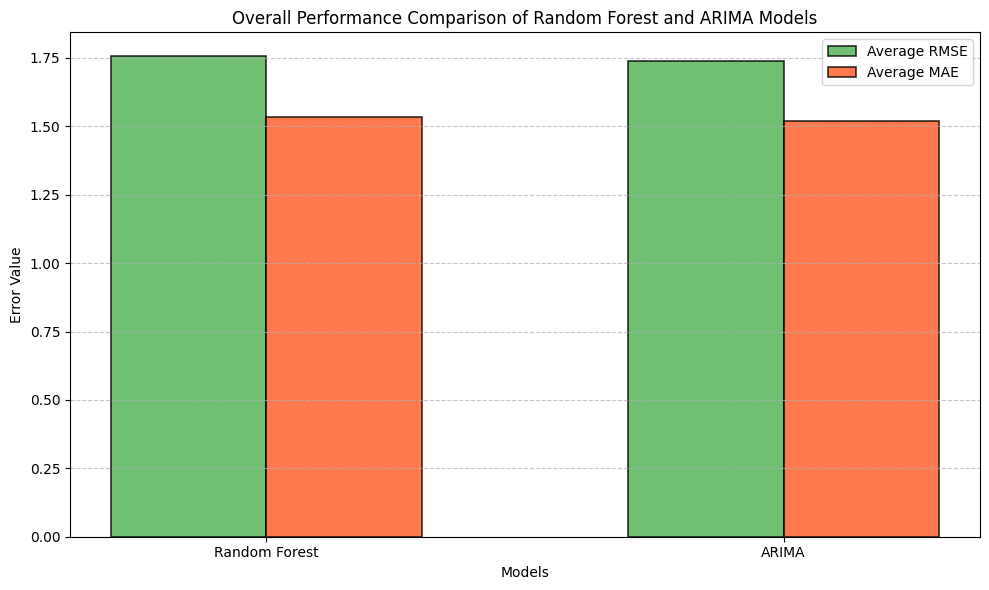

In [168]:
import matplotlib.pyplot as plt

# Average RMSE and MAE values for Random Forest and ARIMA
models = ['Random Forest', 'ARIMA']
average_rmse = [1.7559, 1.7385]
average_mae = [1.5324, 1.5207]

# Define bar width and positions
bar_width = 0.3
indices = range(len(models))

# Create the bar chart
plt.figure(figsize=(10, 6))

# Use different colors for RMSE and MAE
plt.bar(indices, average_rmse, width=bar_width, label='Average RMSE', color='#4CAF50', edgecolor='black', linewidth=1.2, alpha=0.8)
plt.bar([i + bar_width for i in indices], average_mae, width=bar_width, label='Average MAE', color='#FF5722', edgecolor='black', linewidth=1.2, alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Error Value')
plt.title('Overall Performance Comparison of Random Forest and ARIMA Models')
plt.xticks([i + bar_width / 2 for i in indices], models)
plt.legend()

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


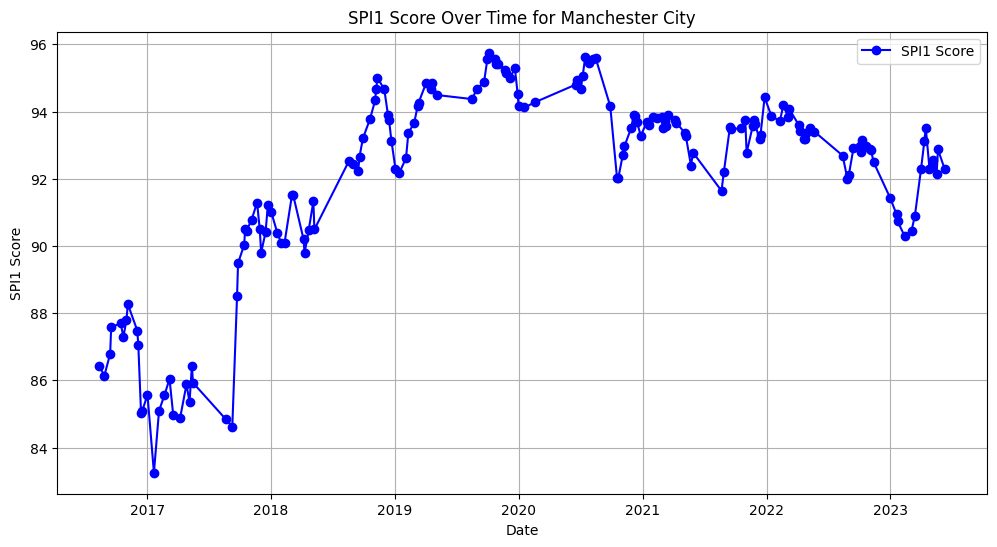

In [161]:

# Filter the data for Chelsea FC Women
chelsea_women_data = cleaned_data[cleaned_data['team1'] == 'Manchester City'].sort_values(by='date')

# Plot the SPI1 score over time
plt.figure(figsize=(12, 6))
plt.plot(chelsea_women_data['date'], chelsea_women_data['spi1'], marker='o', linestyle='-', color='b', label='SPI1 Score')

# Adding title and labels
plt.title('SPI1 Score Over Time for Manchester City')
plt.xlabel('Date')
plt.ylabel('SPI1 Score')
plt.legend()
plt.grid()
plt.show()
